In this file the single variable linear model is implmented. After loading the data, we design a cross-validation method which is used for time series data, with a rolling window of predictions. The model is a SARMA (2, 0)x(1, 0)24.

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import MinMaxScaler

In [2]:
import os
path = os.path.join(os.path.expanduser('~'), 'Documents', 'for_edit', 'GERMANY_WITH_NAN.xlsx')
print (path)

/home/giorgos/Documents/for_edit/GERMANY_WITH_NAN.xlsx


In [3]:
df = pd.read_excel(path)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.set_index('Date Time')
df.index = pd.to_datetime(df.index)
df= df[['Actual_Load']]
df

,Actual_Load
Date Time,
2012-10-01 01:00:00,39296.0
2012-10-01 02:00:00,39623.0
2012-10-01 03:00:00,41180.0
2012-10-01 04:00:00,44793.0
2012-10-01 05:00:00,53632.0
...,...
2015-02-02 13:00:00,68624.0
2015-02-02 14:00:00,67280.0
2015-02-02 15:00:00,66108.0


In [4]:
def evaluate_performance(predictions, actual):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors/actual))*100
    return mse,rmse,mae,mape

In [5]:
#Make sure that the dataset is the correct one, without missing values in the x axis(time)
#In timeseries data, missing values on the x axis could have asignificant impact on the quality of the predictions
df= df.interpolate()
df.loc['2012-10-24 10:00:00']

Actual_Load    64579.0
Name: 2012-10-24 10:00:00, dtype: float64

For the correct evaluation of the predictions, the application of cross-validation is useful. The size of the training set must be fixed so that we do not favor subsequent checks with a larger training set. For this purpose, we move the training data window by one day. 

The training of the model and the predictions procedure is repeated for 494 days so as to use all the available data. This procedure is implemented as a form of cross-validation which is well-established for time series cases where cutting off pieces from the training set is prohibited.

In [6]:
from sklearn.model_selection import TimeSeriesSplit
splits=494
horizon=24
tss = TimeSeriesSplit(n_splits=splits,max_train_size=24*30*12, test_size=horizon)
df = df.sort_index()

In [7]:
# for train_idx, val_idx in tss.split(df):
#     print("TRAIN:", train_idx.shape, "TEST:", val_idx.shape)

In [8]:
fold = 0
preds = []
mse=[]
rmse=[]
mae=[]
mape=[]
WINDOW_SIZE = 25
number_of_fold = 1
hourly_errors = np.zeros(shape=(splits,horizon))
fold_counter=0
full_real = np.zeros(shape=(splits,horizon))

for train_idx, val_idx in tss.split(df):
    if number_of_fold<splits:
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        sc = MinMaxScaler()
        train = sc.fit_transform(train)
        test= sc.fit_transform(test)

        model = AutoReg(train, lags=[1, 2, 24,25,26])
        model_fit = model.fit()

        data_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
        dataY_real=sc.inverse_transform(test)
        predictions = sc.inverse_transform(data_predict.reshape(-1, 1)) 
        for i in range(24):
            hourly_errors[fold_counter,i]=predictions[i]-dataY_real[i]
            full_real[fold_counter,i] = dataY_real[i]


        mse1,rmse1,mae1,mape1 = evaluate_performance(predictions, dataY_real)    
        fold_counter=fold_counter+1
        mse.append(mse1)
        rmse.append(rmse1)
        mae.append(mae1)
        mape.append(mape1)
        number_of_fold=number_of_fold+1

scores=pd.DataFrame(list(zip(mse, rmse,mae,mape)),columns=['mse','rmse','mae','mape'])
#scores

Aftewards we need to create the dataframes so as to store the results properly

THe hourly evaluations will measure how well the model predicts for each hour ahead

In [9]:
cols = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']
hourly_evaluations= pd.DataFrame(hourly_errors,columns=cols)
#hourly_evaluations

In [10]:
#This dataframe just holds the actual values
cols = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']
aa= pd.DataFrame(full_real,columns=cols)

In [11]:
mse=[]
rmse=[]
mae=[]
mape=[]
her = np.zeros(shape=(splits,4))
for i in range(horizon):
    temp = hourly_errors[0:splits-1,i]
    mse1 = np.square(temp).mean()
    rmse1 = np.sqrt(mse1)
    mae1 = np.abs(temp).mean()
    mape1 = np.mean(np.abs(temp/full_real[0:splits-1,i]))*100
    mse.append(mse1)
    rmse.append(rmse1)
    mae.append(mae1)
    mape.append(mape1)
    
hourly_scores=pd.DataFrame(list(zip(mse, rmse,mae,mape)),columns=['mse','rmse','mae','mape'])
hourly_scores

,mse,rmse,mae,mape
0,1.588474e+07,3985.566334,3346.041695,5.942804
1,9.933074e+06,3151.677992,2547.026672,4.692797
2,6.312992e+06,2512.566747,1997.231965,3.846825
3,8.782555e+06,2963.537539,2562.434625,4.966701
4,1.604732e+07,4005.910251,3467.122782,7.025100
5,2.991838e+07,5469.769779,4815.639284,10.263694
6,4.334556e+07,6583.734283,6013.397407,13.415657
7,5.231999e+07,7233.255593,6769.919743,15.577362
8,5.505825e+07,7420.124706,7011.936844,16.302040
9,5.202946e+07,7213.145126,6832.297265,15.792051


Finally we print out some plots

The hourly errors will allows us to examine how good the predictions are for each hour ahead. From the chart below, we can see that the model fails to produce accurate predictions. 

Text(0, 0.5, 'MAPE')

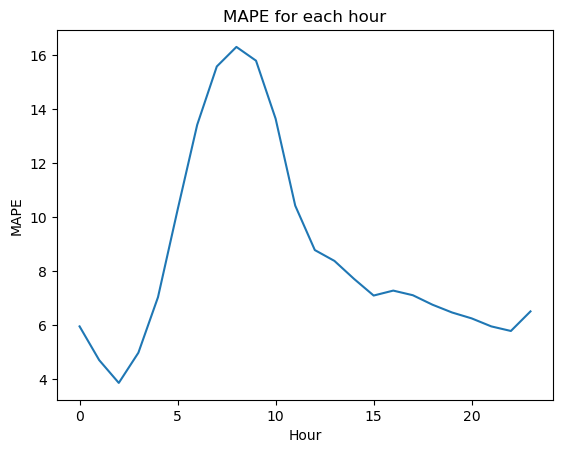

In [12]:
ax = hourly_scores['mape'].plot(title='MAPE for each hour')
ax.set_xlabel("Hour")
ax.set_ylabel("MAPE")

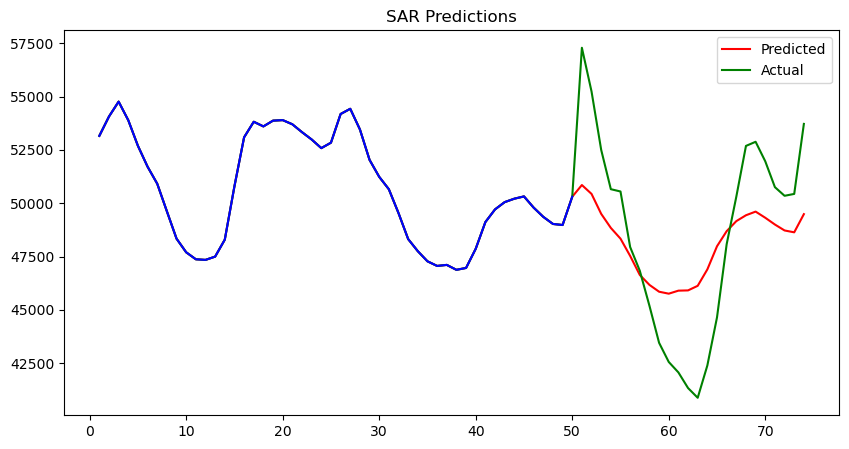

In [13]:
data = sc.inverse_transform(train) 
plt.figure(figsize=(10,5))
prognose = np.concatenate((data[-50:],predictions))
real = np.concatenate((data[-50:],dataY_real))
plt.plot(range(1,len(prognose)+1), prognose, 'r',label='Predicted')
plt.plot(range(1,len(real)+1), real, 'g',label='Actual')
plt.plot(range(1,len(data[-50:])+1), data[-50:], 'b')
plt.title('SAR Predictions')
plt.legend()
plt.show()

In [14]:
scores2 = scores["mape"].mean()
print(scores2)

8.576604950470404


Save the results to new files

In [15]:
# scores.to_excel('SINGLE_SAR_SCORES_GER.xlsx', sheet_name='AR_SCORES_GER')
# hourly_scores.to_excel('SINGLE_SAR_HOURLY_SCORES_GER.xlsx', sheet_name='AR_HOURLY_SCORES_GER')
# hourly_evaluations.to_excel('SINGLE_SAR_HOURLY_ERRORS_GER.xlsx', sheet_name='AR_HOURLY_ERRORS_GER')
# aa.to_excel('SINGLE_SAR_HOURLY_REAL_GER.xlsx', sheet_name='AR_HOURLY_REAL_GER')